# Fermion Chain to Boson Chain

To properly work with Qutip we have to figure out how to incorporate fermions since there is no dedicated operator for that in this toolbox. There are however boson operators. Therefore **we can just use Jorda-Wigner transforms to express our fermionic operators (even with spins, we have to figure that one out) in terms of the JW string times a bosoni operator**. This is what we do here

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from qutip import  *

In [59]:
def create_fermion_op(Nsites):
    # create fermions from quspin bosons and JW strings
    C_list = []
    for site_j in range(0,Nsites):
        # create the string
        JW_string = [identity(2)]*Nsites
        for l in range(0,site_j):
            JW_string[l] = (1j*np.pi*b.dag()*b).expm()
        JW_string[site_j] = b
        # tensor product the string to get the new fermion operator at site_j
        C_list.append(tensor(JW_string))
    return C_list

def create_lindblad_op(Nsites, operator_list ,collapse_type):
    # creates the operators necesary for the non-unitrary dynamics i.e
    # collapse operatos and the operators for the expectation values
    # collapse_type = "number" or "ladder"
    collapse_ops = []
    expect_ops = []

    for site_j in range(0,Nsites):
        density_op = operator_list[site_j].dag()*operator_list[site_j]
        expect_ops.append(density_op)
        
        if collapse_type=="number":
            collapse_ops.append(np.sqrt(gamma)*density_op)
        else: 
            collapse_ops.append(np.sqrt(gamma)*operator_list[site_j])
    
    return collapse_ops, expect_ops

def gen_gauss_init(l0, sigma, Nsites):
    # creates a gaussian initial condition centerd on l0 with bandwidth sigma
    a = 1 # lattice spacing
    band_width = (sigma*a)**2 # the lower the number the more it localizes
    
    psi0 = [np.exp(-(0.5*a/band_width)*(l-l0)**2) for l in range(0,Nsites)]
    # normalize
    magnitude = np.dot(psi0,psi0)
    psi0 = psi0/np.sqrt(magnitude)
    return psi0
    

# 1D-Hopping Chain

In [63]:
L = 6 # Num of sites
D = 2 # local hilbert space
gamma = 0.2 # the dephasing term for the collapse operators
max_t = 50 # maximum time
tsteps = 100 # number of time steps
J = np.ones(L) # interaction
J_contact = 5.0
# Here we could place a a point contact if we want
J[L-4] = J_contact
J[L-3] = J_contact
collapse_op = "number" # either "number" or "ladder"

b = destroy(2) # annihilation

initial_conditions = np.zeros(L**2) # initial conditions of the density matrix
initial_conditions[0] = 1.0



36

In [61]:
# initialize the system
c_list = create_fermion_op(L)

# create the hamiltonian in terms of the fermion operators
ident_tensor = tensor([identity(D)]*L) 
H = 0*ident_tensor

for site_j in range(0,L-1):
    H += -0.5*J[site_j]*(c_list[site_j].dag()*c_list[site_j+1]+c_list[site_j+1].dag()*c_list[site_j] )

collapse_ops, expect_ops = create_lindblad_op(L, c_list ,collapse_op)
# add the energy to also track it
expect_ops.append(H)

# now initialize the density matrix
basis_list = []

# Create the basis vectors, for this case there is a !!single!! spin up
for site in range(0,L):
    # initialize everything in down state
    single_state_list = [basis(D,0)]*L
    # flip the spin up the spin in site
    single_state_list[site] = basis(D,1)
    # notice how there is only one spin up (one particle states)
    ket = tensor(single_state_list)
    basis_list.append(ket)

# initialize the density matrix
# make all possible 2 elemet combinations where order matters so we can get the density matrix
combination_list = list(itertools.product(basis_list, basis_list))

# initialize a density matrix object that is full of zeros
rho = 0*combination_list[0][0]*combination_list[0][1].dag()

# build the density matrix
for i in range(0,len(combination_list)):
    rho += initial_conditions[i]*combination_list[i][0]*combination_list[i][1].dag()
    

In [62]:
times = np.linspace(0.0, max_t, tsteps)

result = mesolve(H, rho, times, c_ops=collapse_ops , e_ops=expect_ops)

result

KeyboardInterrupt: 

Text(0, 0.5, 'Energy')

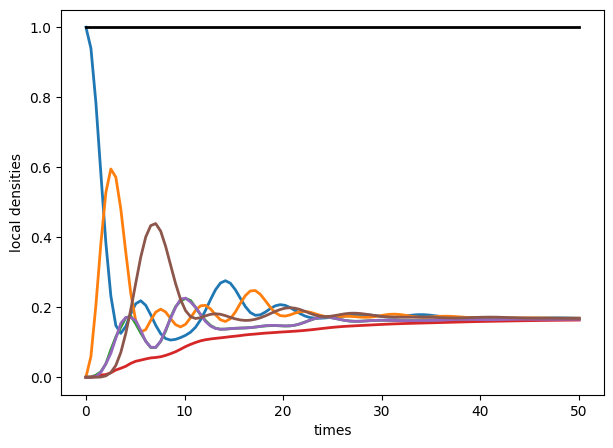

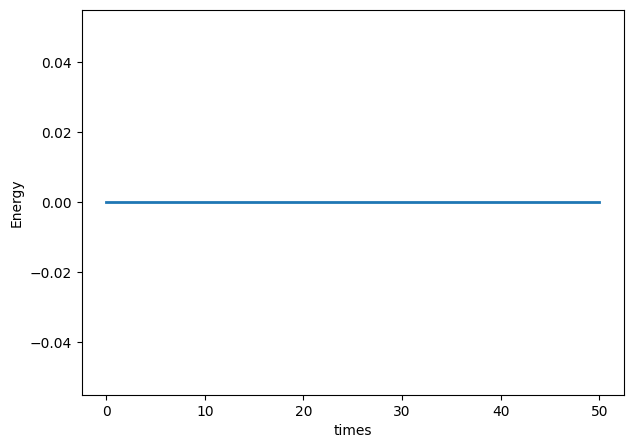

In [6]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

# plot
for i in range(0,len(result.expect)-1):
    ax.plot(times, result.expect[i], linewidth=2.0)
    
# get the total particle number
# get the sum of the local densities
n_tot = np.sum(result.expect, axis=0)
ax.plot(times, n_tot, c='black', linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("local densities")

plt.savefig("../plots/densities_L={}_Jc={}.pdf".format(L,J_contact))

fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(times, result.expect[-1], linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("Energy")



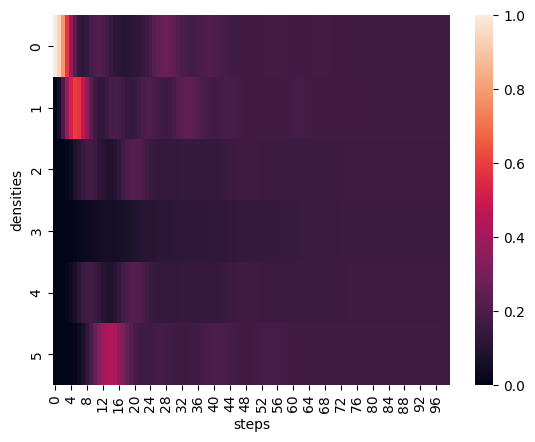

In [7]:

xt = np.linspace(0,max_t,5)
# plot the occupations as a heatmap with lattice site in the y axis and time on the x
ax = sns.heatmap(result.expect[:-1])
ax.set_xlabel("steps")
ax.set_ylabel("densities")

plt.savefig("../plots/trajectory_L={}_Jc={}.png".format(L,J_contact), dpi=300)


# With Gaussian initial state

In [57]:
len(initial_conditions)

6

[1.32922609e-01 9.82172618e-01 1.32922609e-01 3.29482207e-04
 1.49584691e-08 1.24383966e-14]


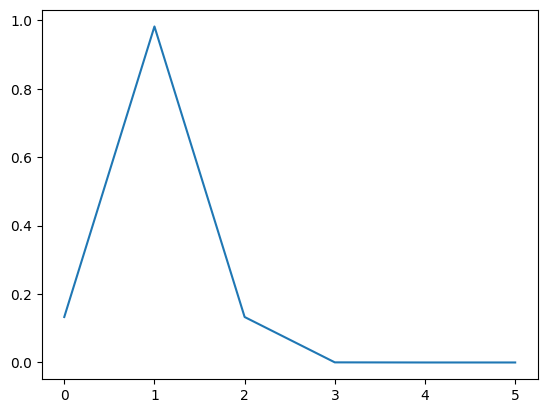

In [55]:
L = 6 # Num of sites
D = 2 # local hilbert space
gamma = 0.2 # the dephasing term for the collapse operators
max_t = 50 # maximum time
tsteps = 100 # number of time steps
J = np.ones(L) # interaction
J_contact = 1.0
# Here we could place a a point contact if we want
J[L-4] = J_contact
J[L-3] = J_contact
collapse_op = "number" # either "number" or "ladder"

b = destroy(2) # annihilation

initial_conditions = gen_gauss_init(1, 0.5, L)
print(initial_conditions)
plt.plot(initial_conditions)

In [56]:
# initialize the system
c_list = create_fermion_op(L)

# create the hamiltonian in terms of the fermion operators
ident_tensor = tensor([identity(D)]*L) 
H = 0*ident_tensor

for site_j in range(0,L-1):
    H += -0.5*J[site_j]*(c_list[site_j].dag()*c_list[site_j+1]+c_list[site_j+1].dag()*c_list[site_j] )

collapse_ops, expect_ops = create_lindblad_op(L, c_list ,collapse_op)
# add the energy to also track it
expect_ops.append(H)

# now initialize the density matrix
basis_list = []

# Create the basis vectors, for this case there is a !!single!! spin up
for site in range(0,L):
    # initialize everything in down state
    single_state_list = [basis(D,0)]*L
    # flip the spin up the spin in site
    single_state_list[site] = basis(D,1)
    # notice how there is only one spin up (one particle states)
    ket = tensor(single_state_list)
    basis_list.append(ket)

# initialize the density matrix
# make all possible 2 elemet combinations where order matters so we can get the density matrix
combination_list = list(itertools.product(basis_list, basis_list))

# initialize a density matrix object that is full of zeros
rho = 0*combination_list[0][0]*combination_list[0][1].dag()

# build the density matrix
for i in range(0,len(combination_list)):
    rho += initial_conditions[i]*combination_list[i][0]*combination_list[i][1].dag()

IndexError: index 6 is out of bounds for axis 0 with size 6